In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

import sem
import story_generation
from event_schemas import LinearMLP, BasicRNN, LinearRNN, BoundedRNN
import hrr

### functions

In [19]:
# find closest vector to prediction in a pool of objects using euclidean distance
def eucl_match(prediction, objects):
    dists = list(map(lambda x : np.linalg.norm(prediction - x), objects))
    index = dists.index(min(dists)) 
    return objects[index]

In [82]:
# semantic error between prediction and actual components of scene
def semantic_error(constants, predicted_scene, semantic_truth):
    # decode fillers of predicted scene from roles
    decode_subj = hrr.decode(predicted_scene, constants['placeholders']['subject'])
    decode_subj_noun = hrr.decode(decode_subj, constants['placeholders']['noun'])
    decode_subj_property = hrr.decode(decode_subj, constants['placeholders']['property'])
    decode_verb = hrr.decode(predicted_scene, constants['placeholders']['verb'])
    decode_obj = hrr.decode(predicted_scene, constants['placeholders']['object'])
    decode_obj_noun = hrr.decode(decode_obj, constants['placeholders']['noun'])
    decode_obj_property = hrr.decode(decode_obj, constants['placeholders']['property'])
    
    # normalize pool of filler vectors
    normalized_nouns = list(map(lambda x: hrr.normalize(x), constants['nouns'].values())) + list(map(lambda x: hrr.normalize(x['vector']), actors))
    normalized_verbs = list(map(lambda x: hrr.normalize(x), constants['verbs'].values()))
    normalized_properties = list(map(lambda x: hrr.normalize(x), constants['properties'].values()))
    
    # match each predicted filler to the closest generative filler 
    pred_subj_noun = eucl_match(hrr.normalize(decode_subj_noun), normalized_nouns)
    pred_subj_property = eucl_match(hrr.normalize(decode_subj_property), normalized_properties)
    pred_verb = eucl_match(hrr.normalize(decode_verb), normalized_verbs)
    pred_obj_noun = eucl_match(hrr.normalize(decode_obj_noun), normalized_nouns)
    pred_obj_property = eucl_match(hrr.normalize(decode_obj_property), normalized_properties)

    # semantic error is fraction of predicted fillers that are different from the true filler
    incorrect = 0
    incorrect += int(list(pred_subj_noun) != list(hrr.normalize(semantic_truth['subject_noun'])))
    incorrect += int(list(pred_subj_property) != list(hrr.normalize(semantic_truth['subject_property'])))
    incorrect += int(list(pred_verb) != list(hrr.normalize(semantic_truth['verb'])))
    incorrect += int(list(pred_obj_noun) != list(hrr.normalize(semantic_truth['object_noun'])))
    incorrect += int(list(pred_obj_property) != list(hrr.normalize(semantic_truth['object_property'])))
    if incorrect == 0:
        print "perfect"
    return incorrect/5.0

In [141]:
# articiailly encode and decode scenes - roles taken as parameters to allow for different role encoding schemes
def demo_decoding_accuracy(trials, num_fillers, dim, noun, prop, verb, subj, obj):
    correct_noun = 0.0; correct_verb = 0.0; correct_noun_noise = 0.0; correct_verb_noise = 0.0
    for t in range(trials):
        # embed fillers
        noun_fillers = []
        verb_fillers = []
        for i in range(num_fillers):
            noun_fillers.append(hrr.embed_2d(dim, None))
            verb_fillers.append(hrr.embed_2d(dim, None))
        sn = noun_fillers[0]
        sp = hrr.embed_2d(dim, None)
        v = verb_fillers[0]
        op = hrr.embed_2d(dim, None)
        on = hrr.embed_2d(dim, None)
        normalized_noun_fillers = list(map(lambda x: hrr.normalize(x), noun_fillers))
        normalized_verb_fillers = list(map(lambda x: hrr.normalize(x), verb_fillers))

        # construct scene by encoding
        subject_composite = hrr.encode(sn, noun) + hrr.encode(sp, prop)
        object_composite = hrr.encode(on, noun) + hrr.encode(op, prop)
        scene = hrr.encode(subj, subject_composite) + hrr.encode(verb, v) + hrr.encode(obj, object_composite)
        
        # reconstruct fillers by decoding with role
        noise = hrr.normalize(np.random.random(dim) * 2 - 1) * 1
        prediction_noun = hrr.normalize(hrr.decode(hrr.decode(scene, subj), noun))
        prediction_verb = hrr.normalize(hrr.decode(scene, verb))
        prediction_noun_noise = hrr.normalize(hrr.decode(hrr.decode(hrr.normalize(scene) + noise, subj), noun))
        prediction_verb_noise = hrr.normalize(hrr.decode(hrr.normalize(scene) + noise, verb))
        
        # evaluate prediction match against all fillers
        correct_noun += int(list(eucl_match(prediction_noun, normalized_noun_fillers)) == list(hrr.normalize(sn)))
        correct_noun_noise += int(list(eucl_match(prediction_noun_noise, normalized_noun_fillers)) == list(hrr.normalize(sn)))
        correct_verb += int(list(eucl_match(prediction_verb, normalized_verb_fillers)) == list(hrr.normalize(v)))
        correct_verb_noise += int(list(eucl_match(prediction_verb_noise, normalized_verb_fillers)) == list(hrr.normalize(v)))            
    return correct_noun/trials, correct_noun_noise/trials, correct_verb/trials, correct_verb_noise/trials


### basic encoding and decoding

In [21]:
dim = 5

In [22]:
role1 = hrr.embed_2d(dim, None)
filler1 = hrr.embed_2d(dim, None)
ob1 = hrr.encode(role1, filler1)
print role1
print filler1
print ob1

[-0.02519965  0.41659313  0.43657806  0.44437851  0.39305243]
[-1.0154978   1.09026382  0.94691346 -0.27775569  0.0389588 ]
[ 0.76987696 -0.18475714 -0.10486962  0.44150971  0.38205471]


In [23]:
role2 = hrr.embed_2d(dim, None)
filler2 = hrr.embed_2d(dim, None)
ob2 = hrr.encode(role2, filler2)
print role2
print filler2
print ob2

[ 0.48212957  0.03511354 -0.30247246  0.72618373  1.18228083]
[-1.38854042 -0.42877951  0.55251532 -1.4924425   0.17633956]
[-0.31755189 -0.7393809  -0.96510799 -1.37030848 -2.08752453]


In [24]:
print hrr.normalize(hrr.decode(ob1, role1))
print hrr.normalize(filler1)
print ""
print hrr.normalize(hrr.decode(ob2, role2))
print hrr.normalize(filler2)

[ 0.19654162  0.60258335  0.59947141  0.34727259  0.34394837]
[-0.5681048   0.60993152  0.52973634 -0.1553862   0.02179491]

[-0.60416384 -0.33672495 -0.177945   -0.41762634 -0.56171717]
[-0.64215156 -0.19829558  0.25551908 -0.69020264  0.0815509 ]


In [25]:
print hrr.normalize(hrr.decode(ob1+ob2, role1))
print hrr.normalize(filler1)
print 
print hrr.normalize(hrr.decode(ob1+ob2, role2))
print hrr.normalize(filler2)

[-0.61110909 -0.44203585 -0.39768676 -0.41465848 -0.31788925]
[-0.5681048   0.60993152  0.52973634 -0.1553862   0.02179491]

[-0.50524479 -0.20980466 -0.18452454 -0.59766552 -0.55628799]
[-0.64215156 -0.19829558  0.25551908 -0.69020264  0.0815509 ]


### noisy reconstruction

##### accuracy decline with increased number of fillers

In [85]:
dim = 50
trials = 1000

res_noun = {}
res_noun_noise = {}
res_verb = {}
res_verb_noise = {}

# orthonormal encoding of role vectors provide large improvement
noun = hrr.embed_2d(dim, None)
prop = hrr.embed_2d(dim, None)
verb = hrr.embed_2d(dim, None)
subj = hrr.embed_2d(dim, None)
obj = hrr.embed_2d(dim, None)
    
for num in range(1, 21):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, noun, prop, verb, subj, obj)   
    
    res_noun[num] = a
    res_noun_noise[num] = b
    res_verb[num] = c
    res_verb_noise[num] = d

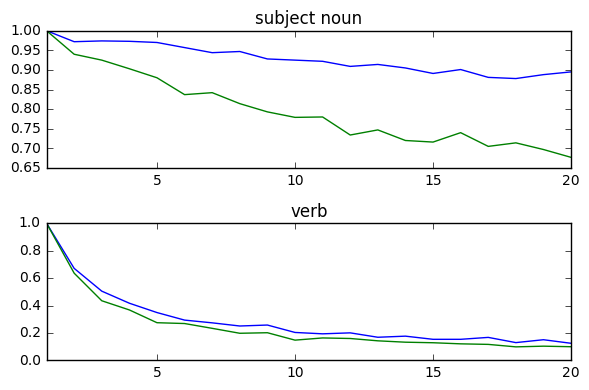

In [86]:
plt.subplot(2, 1, 1)
plt.plot(res_noun.keys(), res_noun.values())
plt.plot(res_noun_noise.keys(), res_noun_noise.values())
plt.xlim([1, 20])
plt.title("subject noun")
plt.subplot(2, 1, 2)
plt.plot(res_verb.keys(), res_verb.values())
plt.plot(res_verb_noise.keys(), res_verb_noise.values())
plt.xlim([1, 20])
plt.title("verb")
plt.tight_layout()
plt.show()

##### one-hot roles accuracy decline with increased number of fillers

In [87]:
dim = 50
trials = 1000

res_noun = {}
res_noun_noise = {}
res_verb = {}
res_verb_noise = {}

# orthonormal encoding of role vectors provide large improvement
noun = np.zeros(dim)
noun[0] = 1
prop = np.zeros(dim)
prop[1] = 1
verb = np.zeros(dim)
verb[2] = 1
subj = np.zeros(dim)
subj[3] = 1
obj = np.zeros(dim)
obj[4] = 1
        
for num in range(1, 21):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, noun, prop, verb, subj, obj)   
    
    res_noun[num] = a
    res_noun_noise[num] = b
    res_verb[num] = c
    res_verb_noise[num] = d

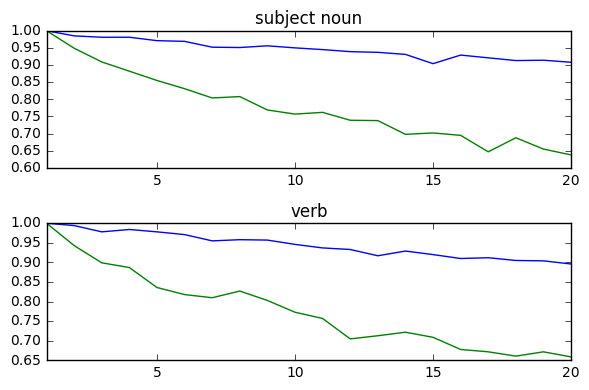

In [88]:
plt.subplot(2, 1, 1)
plt.plot(res_noun.keys(), res_noun.values())
plt.plot(res_noun_noise.keys(), res_noun_noise.values())
plt.xlim([1, 20])
plt.title("subject noun")
plt.subplot(2, 1, 2)
plt.plot(res_verb.keys(), res_verb.values())
plt.plot(res_verb_noise.keys(), res_verb_noise.values())
plt.xlim([1, 20])
plt.title("verb")
plt.tight_layout()
plt.show()

##### accuracy increase with increased dimensionality

In [142]:
num = 50
trials = 1000

res_noun = []
res_noun_noise = []
res_verb = []
res_verb_noise = []

max_dim = 155
for dim in np.arange(5, max_dim, 5):
        
    noun = hrr.embed_2d(dim, None)
    prop = hrr.embed_2d(dim, None)
    verb = hrr.embed_2d(dim, None)
    subj = hrr.embed_2d(dim, None)
    obj = hrr.embed_2d(dim, None)

    a, b, c, d = demo_decoding_accuracy(trials, num, dim, noun, prop, verb, subj, obj)   
    
    res_noun.append(a)
    res_noun_noise.append(b)
    res_verb.append(c)
    res_verb_noise.append(d)

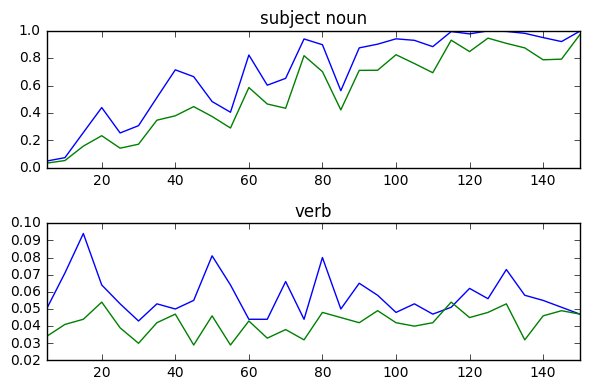

In [146]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(5, max_dim, 5), res_noun)
plt.plot(np.arange(5, max_dim, 5), res_noun_noise)
plt.xlim([5, max_dim-5])
plt.title("subject noun")
plt.subplot(2, 1, 2)
plt.plot(np.arange(5, max_dim, 5), res_verb)
plt.plot(np.arange(5, max_dim, 5), res_verb_noise)
plt.xlim([5, max_dim-5])
plt.title("verb")
plt.tight_layout()
plt.show()

##### one-hot roles accuracy increase with increased dimensionality

In [147]:
num = 50
trials = 1000

res_noun = []
res_noun_noise = []
res_verb = []
res_verb_noise = []

max_dim = 155
for dim in np.arange(5, max_dim, 5):
        
    noun = np.zeros(dim)
    noun[0] = 1
    prop = np.zeros(dim)
    prop[1] = 1
    verb = np.zeros(dim)
    verb[2] = 1
    subj = np.zeros(dim)
    subj[3] = 1
    obj = np.zeros(dim)
    obj[4] = 1

    a, b, c, d = demo_decoding_accuracy(trials, num, dim, noun, prop, verb, subj, obj)   
    
    res_noun.append(a)
    res_noun_noise.append(b)
    res_verb.append(c)
    res_verb_noise.append(d)

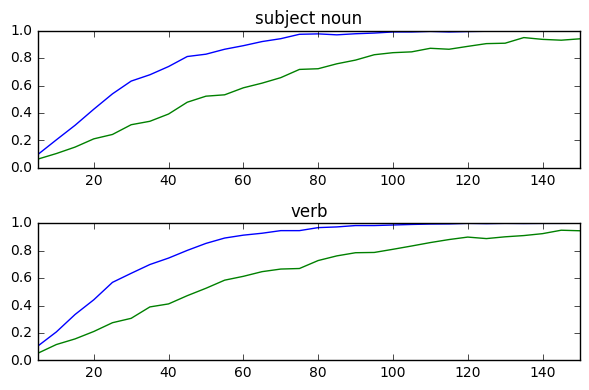

In [148]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(5, max_dim, 5), res_noun)
plt.plot(np.arange(5, max_dim, 5), res_noun_noise)
plt.xlim([5, max_dim-5])
plt.title("subject noun")
plt.subplot(2, 1, 2)
plt.plot(np.arange(5, max_dim, 5), res_verb)
plt.plot(np.arange(5, max_dim, 5), res_verb_noise)
plt.xlim([5, max_dim-5])
plt.title("verb")
plt.tight_layout()
plt.show()

##### required dimensionality to maintain accuracy threshold with increased number of fillers

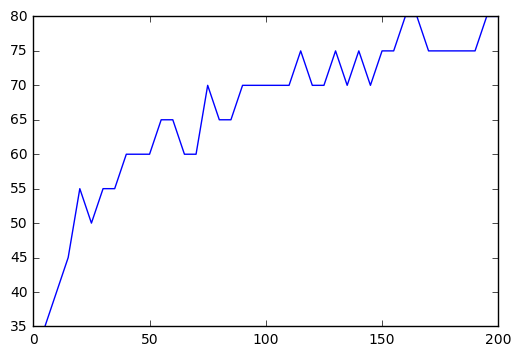

In [129]:
num = 50
trials = 1000

res_noun = []
res_noun_noise = []
res_verb = []
res_verb_noise = []

# orthonormal encoding of role vectors provide large improvement
max_dim = 305
#for dim in range(3, 51):
nums=[]
matches = []
for num in np.arange(5, 205, 5):
    nums.append(num)
    for dim in np.arange(5, max_dim, 5):

        noun = np.zeros(dim)
        noun[0] = 1
        prop = np.zeros(dim)
        prop[1] = 1
        verb = np.zeros(dim)
        verb[2] = 1
        subj = np.zeros(dim)
        subj[3] = 1
        obj = np.zeros(dim)
        obj[4] = 1

        a, b, c, d = demo_decoding_accuracy(trials, num, dim, noun, prop, verb, subj, obj)   

        res_noun.append(a)
        res_noun_noise.append(b)
        res_verb.append(c)
        res_verb_noise.append(d)
        
        if a >= 0.9:
            matches.append(dim)
            break
    if len(nums) > len(matches):
        matches.append(0)
plt.plot(nums, matches)

In [144]:
#plt.plot(nums, matches)
#plt.xlabel("number of fillers")
#plt.ylabel("dimensionality to acheive 90% accuracy")
#plt.xlim([5, 200])

### comparing different scene structures

##### decoding accuracy with increased additive noise

In [149]:
dim = 50
var = []
res = []
for sum_length in range(1, 10):
    var.append(sum_length)
    correct = 0.0
    for i in range(1000):
        fillers = []
        for j in range(10):
            fillers.append(hrr.embed_2d(dim, None))
        normalized_fillers = list(map(lambda x: hrr.normalize(x), fillers))

        role = hrr.embed_2d(dim, None)
        scene = hrr.encode(role, fillers[0])
        for j in range(sum_length - 1):
            add = hrr.encode(hrr.embed_2d(dim, None), hrr.embed_2d(dim, None))
            scene += add
        pred = hrr.normalize(hrr.decode(scene, role))
        correct += int(list(eucl_match(pred, normalized_fillers)) == list(hrr.normalize(fillers[0])))
    res.append(correct/1000.0)

(0, 1)

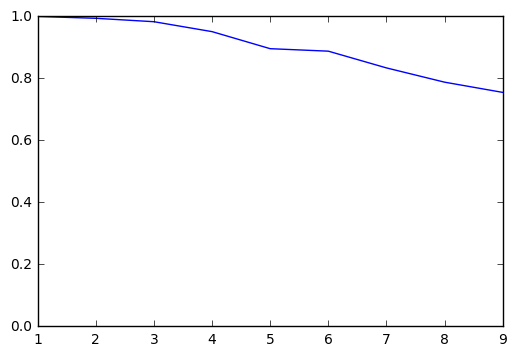

In [150]:
plt.plot(var, res)
plt.ylim(0, 1)

##### decoding accuracy with increased compositional noise

In [153]:
# compositional limits
dim = 50
var = []
res = []
for composition_depth in range(10):
    var.append(composition_depth)
    correct = 0.0
    for i in range(1000):
        fillers = []
        for j in range(10):
            fillers.append(hrr.embed_2d(dim, None))
        normalized_fillers = list(map(lambda x: hrr.normalize(x), fillers))

        roles = []
        scene = fillers[0]
        for j in range(composition_depth):
            current_role = hrr.embed_2d(dim, None)
            roles.append(current_role)
            scene = hrr.encode(scene, current_role)
        pred = scene
        for role in reversed(roles):
            pred = hrr.decode(pred, role)

        correct += int(list(eucl_match(pred, normalized_fillers)) == list(hrr.normalize(fillers[0])))
    res.append(correct/1000.0)

(0, 1)

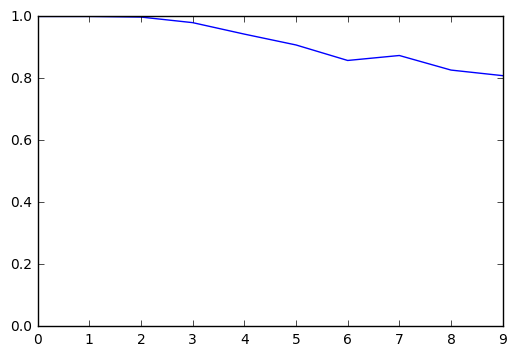

In [154]:
plt.plot(var, res)
plt.ylim(0, 1)